In [1]:
IS_COLAB = True

In [2]:
import sys
import os
import gc
import torch
import pandas as pd
import numpy as np
import glob

if IS_COLAB:
    # using google colab
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = os.path.join('/content', 'drive', 'My Drive', 'OpportunityUCIDataset')
    os.chdir(ROOT)
else:
    # using own pc
    ROOT = os.path.join(os.getcwd(), 'OpportunityUCIDataset')
    os.chdir(ROOT)

print(ROOT)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Mounted at /content/drive
/content/drive/My Drive/OpportunityUCIDataset
Running on the GPU


In [3]:
from torch.utils.data import Dataset, DataLoader

class OpportunityDatasetParsed(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]

        df = pd.read_csv(filename, header = 0)

        # first 15 columns are for data
        data = torch.FloatTensor(
            df.iloc[:, 0:15].values.astype('float'))
        
        # last 3 columns are for label
        label = torch.FloatTensor(
            df.iloc[99, 15:18].values.astype('float'))

        return data, label

In [85]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# dataset constants
data_row_n = 100
data_feature_n = 15
data_output1_n = 3

# model hyperparameter
lstm1_h = 8

# training hyperparameter
num_epochs = 30
batch_size = 32
learning_rate = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # self.conv1 = nn.Conv1d(1, 3, 3)
        # self.conv2 = nn.Conv1d(3, 6, 3)
        # self.conv3 = nn.Conv1d(6, 12, 3)
        # self.conv4 = nn.Conv1d(12, 24, 3)
        # self.pool = nn.MaxPool1d(2)
        # self.lstm1 = nn.LSTM(168, 64)
        # self.lstm2 = nn.LSTM(96, 96)
        # self.lstm3 = nn.LSTM(96, 96)
        # self.fc1 = nn.Linear(64, 16)
        # self.fc2 = nn.Linear(16, 3)
        # self.fc3 = nn.Linear(96, 64)

        self.lstm1 = nn.LSTM(data_feature_n, lstm1_h)
        self.fc1 = nn.Linear(lstm1_h*data_row_n, data_output1_n)
        self.batch_size = batch_size


#     def forward(self, x):
#         x = F.relu(self.conv1(x), inplace=False)
#         #print(x.shape)
#         x = F.relu(self.conv2(x), inplace=False)
#         #print(x.shape)
#         x = F.relu(self.conv3(x), inplace=False)
#         #print(x.shape)
#         x = F.relu(self.conv4(x), inplace=False)
#         #print(x.shape)
#         x = x.view(-1, 1, 24 * 7)
#         #print(x.shape)

#         lstm_out1, h1 = self.lstm1(x)
#         #print(lstm_out1.shape)
#         x_out = self.fc1(lstm_out1[:, -1, :])
#         #print(x_out[:, -1, :].shape)
#         out1 = self.fc2(x_out)
#         #print(lstm_out1.shape)

#         # lstm_out2, h2 = self.lstm2(x - lstm_out1)
#         # out2 = self.fc2(lstm_out2[:, -1, :])

#         # lstm_out3, h3 = self.lstm3(x - lstm_out1 - lstm_out2)
#         # out3 = self.fc3(lstm_out3[:, -1, :])

#         return out1#, out2, out3

    def forward(self, x, h):
        batch_len = x.shape[0]
        # x = F.relu(self.conv1(x), inplace=False)
        # #print(x.shape)
        # x = F.relu(self.conv2(x), inplace=False)
        # print(x.shape)

        x, _ = self.lstm1(x, h)
        #x = x.contiguous().view(batch_len, -1)
        x = x.reshape([batch_len, -1])
        #print(x.shape)
        out = self.fc1(x)
        #print(out.shape)
        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(1, 100, 8).zero_().to(device),
                      weight.new(1, 100, 8).zero_().to(device))
        return hidden
            
loss_function = nn.CrossEntropyLoss()

net = Net().to(device)
print(net)

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Net(
  (lstm1): LSTM(15, 8)
  (fc1): Linear(in_features=800, out_features=3, bias=True)
)


In [86]:
def make_train_step(model, loss_fn, optimizer):

    def train_step(data, labels):
        model.train()
        optimizer.zero_grad()

        data, labels = data.to(device), labels.to(device)

        data = torch.reshape(data, (len(labels), -1, 15))

        label1 = torch.reshape(labels[:, 0:1].long(), (-1,))
        
        output1 = net(data, h)

        loss = loss_function(output1, label1)
        loss.backward()
        optimizer.step()

        #print(loss.item())

        return loss.item()
    
    return train_step

train_step = make_train_step(net, loss_function, optimizer)

In [88]:
data_train_files = glob.glob("dataset_parsed/train/*.csv")

from torch.utils.data.dataset import random_split

h = net.init_hidden(batch_size)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print("Epoch " + str(epoch + 1))

    data_train = OpportunityDatasetParsed(data_train_files)

    # TODO: Need to do the splitting better
    train_dataset, val_dataset = random_split(data_train, [400, 106])

    dataloader_train = DataLoader(train_dataset, batch_size=batch_size,
                    shuffle=True)

    train_losses_temp = []
    for data, labels in dataloader_train:
        loss = train_step(data, labels)

        train_losses_temp.append(loss)

    train_losses.append(np.mean(train_losses_temp))

    with torch.no_grad():
        dataloader_val = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False)
        
        val_losses_temp = []
        for data, labels in dataloader_val:
            net.eval()
            data, labels = data.to(device), labels.to(device)

            label1 = torch.reshape(labels[:, 0:1].long(), (-1,))

            output1 = net(data, h)

            val_loss = loss_function(output1, label1)

            val_losses_temp.append(val_loss.item())
        
        val_losses.append(np.mean(val_losses_temp))

#print(net.state_dict())

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


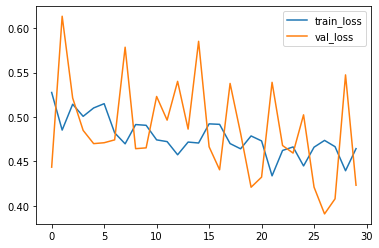

In [79]:
import matplotlib.pyplot as plt

plt.plot(range(0, num_epochs), train_losses, label="train_loss")
plt.plot(range(0, num_epochs), val_losses, label="val_loss")

plt.legend()


In [80]:
data_test_files = glob.glob("dataset_parsed/test/*.csv")
data_test = OpportunityDatasetParsed(data_test_files)

with torch.no_grad():
    dataloader_test = DataLoader(data_test, batch_size=batch_size,
                    shuffle=False)
    
    total1 = 0
    correct1 = 0

    for data, labels in dataloader_test:
        net.eval()
        data, labels = data.to(device), labels.to(device)

        label1 = torch.reshape(labels[:, 0:1].long(), (-1,))

        output1 = net(data, h)

        _, predicted1 = torch.max(output1, 1)
        print(predicted1)


        total1 += label1.size(0)


        correct1 += (predicted1 == label1).sum()
    
    accuracy1 = 100 * torch.true_divide(correct1, total1)

    print('Accuracy1: {}'.format(accuracy1))

tensor([2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 0, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 2,
        2, 2, 2, 2, 1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 2], device='cuda:0')
tensor([2, 2, 2, 1, 1, 0, 0, 1, 0], device='cuda:0')
Accuracy1: 66.66666412353516


In [ ]:
# 66.66% accuracy, not bad